Fourier scaling theorem states that for a projection imaging system with source-to-sample distance s_r and sample-to-detector distance s_d, if the geometrical magnification is denoted by M = (s_r + s_d) / s_r, then the intensity at the detector plane is equivalent to a parallel beam propagated by s_d / M, scaled by a factor of M. 

Based on this principle, the image generated by Fourier scaling theorem should agree with the result of wavefront propagation in spherical coordinates (implemented in Wave_propagation_in_spherical_coordinates.ipynb).

In [1]:
import numpy as np
import dxchange
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm import tqdm
from pyfftw.interfaces.numpy_fft import fft2, ifft2, fftshift, ifftshift
from scipy.misc import imresize
from scipy.interpolate import RegularGridInterpolator

In [2]:
PI = 3.1415927

def gen_mesh(max, shape):
    """Generate mesh grid.
    """
    yy = np.linspace(-max[0], max[0], shape[0])
    xx = np.linspace(-max[1], max[1], shape[1])
    res = np.meshgrid(xx, yy)
    return res

def real_imag_to_mag_phase(realpart, imagpart):

    a = realpart + 1j * imagpart
    return np.abs(a), np.angle(a)

def mag_phase_to_real_imag(mag, phase):

    a = mag * np.exp(1j * phase)
    return a.real, a.imag

def plot_img(a):
    plt.figure()
    plt.imshow(a)
    plt.show()
    
def generate_disk(shape, radius, anti_aliasing=5):

    shape = np.array(shape)
    radius = int(radius)
    x = np.linspace(-radius, radius, (radius * 2 + 1) * anti_aliasing)
    y = np.linspace(-radius, radius, (radius * 2 + 1) * anti_aliasing)
    xx, yy = np.meshgrid(x, y)
    a = (xx**2 + yy**2 <= radius**2).astype('float')
    res = np.zeros(shape * anti_aliasing)
    center_res = (np.array(res.shape) / 2).astype('int')
    res[center_res[0] - int(a.shape[0] / 2):center_res[0] - int(a.shape[0] / 2) + a.shape[0],
        center_res[1] - int(a.shape[0] / 2):center_res[1] - int(a.shape[0] / 2) + a.shape[1]] = a
    res = gaussian_filter(res, 0.5 * anti_aliasing)
    res = res[::anti_aliasing, ::anti_aliasing]
    return res

def plot_mod_and_phase(arr, figsize=(12, 5), title=None, unwrap=False):
    
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1, 2, 1)
    subfig1 = ax1.imshow(np.abs(arr))
    plt.colorbar(subfig1)
    plt.title('Modulus')
    ax2 = fig.add_subplot(1, 2, 2)
    phase_term = np.angle(arr)
    if unwrap:
        phase_term = np.unwrap(phase_term)
    subfig2 = ax2.imshow(phase_term)
    plt.colorbar(subfig2)
    plt.title('Phase')
    if title is not None:
        plt.suptitle(title)
    plt.show()

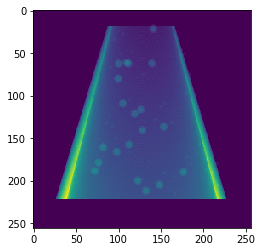

In [3]:
# read in object
grid_delta = np.load('phantom/grid_delta.npy')
grid_beta = np.load('phantom/grid_beta.npy')
# swap axis so that it is in [x, y, z] format
# grid_delta = np.swapaxes(grid_delta, 0, 1)
# grid_beta = np.swapaxes(grid_beta, 0, 1)
plot_img(np.sum(grid_delta, axis=2))

In [9]:
def get_kernel(dist_nm, lmbda_nm, voxel_nm, grid_shape):
    """Get Fresnel propagation kernel for TF algorithm.

    Parameters:
    -----------
    simulator : :class:`acquisition.Simulator`
        The Simulator object.
    dist : float
        Propagation distance in cm.
    """
    k = 2 * PI / lmbda_nm
    u_max = 1. / (2. * voxel_nm[0])
    v_max = 1. / (2. * voxel_nm[1])
    u, v = gen_mesh([v_max, u_max], grid_shape[0:2])
    # H = np.exp(1j * k * dist_nm * np.sqrt(1 - lmbda_nm**2 * (u**2 + v**2)))
    H = np.exp(1j * k * dist_nm) * np.exp(-1j * PI * lmbda_nm * dist_nm * (u ** 2 + v ** 2))

    return H

def free_propagate_projection(wavefront, dist_cm, r_cm, wavelen_nm, psize_cm, h=None):
    
    m = (dist_cm + r_cm) / r_cm
    dist_nm = dist_cm * 1.e7
    dist_eff_nm = dist_nm / m
    r_nm = r_cm * 1.e7
    new_psize_cm = psize_cm * m
    psize_nm = psize_cm * 1.e7
    if h is None:
        h = get_kernel(dist_eff_nm, wavelen_nm, [psize_nm, psize_nm], wavefront.shape)
    wavefront = fftshift(fft2(wavefront)) * h
    wavefront = ifft2(ifftshift(wavefront))
    return wavefront, m

def free_propagate_fresnel(wavefront, dist_cm, wavelen_nm, psize_cm, h=None):
    
    dist_nm = dist_cm * 1.e7
    psize_nm = psize_cm * 1.e7
    if h is None:
        h = get_kernel(dist_nm, wavelen_nm, [psize_nm, psize_nm], wavefront.shape)
    wavefront = fftshift(fft2(wavefront)) * h
    wavefront = ifft2(ifftshift(wavefront))
    return wavefront

Assuming spherical wavefront, we now do a multislice propagation through the object. 

In [10]:
energy_ev = 5000.
s_r_cm = 8
psize_cm = 1.e-7
wavelen_nm = 1240. / energy_ev

In [11]:
def initialize_wavefront(psize_cm, s_r_cm, probe_shape, wavelen_nm, type='spherical'):
    psize_nm = psize_cm * 1.e7
    s_r_nm = s_r_cm * 1.e7
    if type == 'spherical':
        y, x = (np.arange(probe_shape[0], dtype='float64'), np.arange(probe_shape[1], dtype='float64'))
        y = (y - float(y[-1]) / 2) * psize_nm
        x = (x - float(x[-1]) / 2) * psize_nm
        xx, yy = np.meshgrid(x, y)
        r = np.sqrt(xx ** 2 + yy ** 2 + s_r_nm ** 2)
        wavefront = np.exp(-1j * 2 * PI * r / wavelen_nm)
    elif type == 'plane':
        wavefront = np.ones(probe_shape, dtype='complex128')
    return wavefront

def magnify_2d(arr, m):
    ny, nx = arr.shape
    y0, x0 = (np.arange(arr.shape[0]), np.arange(arr.shape[1]))
    f = RegularGridInterpolator((y0, x0), arr, bounds_error=False, fill_value=None)
    ly = ny / m
    lx = nx / m
    y1 = np.linspace((ny - ly) / 2., ny - 1 - (ny - ly) / 2., ny)
    x1 = np.linspace((nx - lx) / 2., nx - 1 - (nx - lx) / 2., nx)
    xx1, yy1 = np.meshgrid(x1, y1)
    pts = np.vstack([yy1.flatten(), xx1.flatten()]).transpose()
    return np.reshape(f(pts), arr.shape)

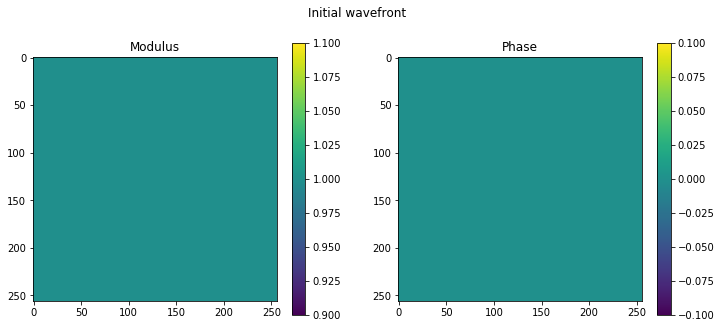

In [12]:
wavefront = initialize_wavefront(psize_cm, s_r_cm, grid_delta.shape[0:2], wavelen_nm, type='plane')
plot_mod_and_phase(wavefront, title='Initial wavefront', unwrap=False)
dxchange.write_tiff(np.angle(wavefront), 'phase', dtype='float32', overwrite=True)
dxchange.write_tiff(np.abs(wavefront), 'mag', dtype='float32', overwrite=True)

100%|██████████| 256/256 [00:06<00:00, 41.44it/s]


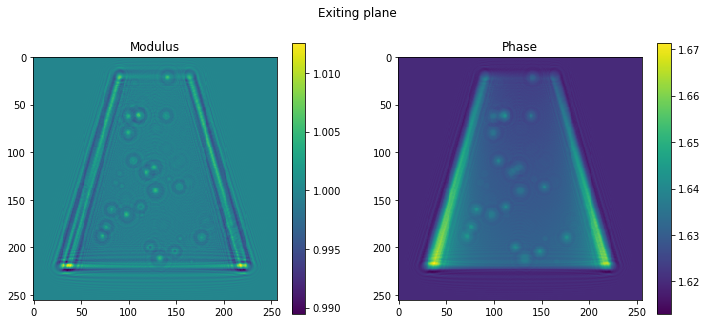

In [13]:
psize_nm = psize_cm * 1.e7
kz = 2 * PI * psize_nm / wavelen_nm
this_psize_cm = psize_cm
for i_slice in tqdm(range(grid_delta.shape[2])):
    delta_slice = grid_delta[:, :, i_slice]
    beta_slice = grid_beta[:, :, i_slice]
    wavefront *= np.exp((kz * delta_slice) * 1j) * np.exp(-kz * beta_slice)
    wavefront, m = free_propagate_projection(wavefront, 
                                             this_psize_cm, 
                                             s_r_cm + i_slice * psize_cm, 
                                             wavelen_nm,
                                             psize_cm)
    wavefront = magnify_2d(wavefront, m)
#     wavefront_real = magnify_2d(np.real(wavefront), m)
#     wavefront_imag = magnify_2d(np.imag(wavefront), m)
#     wavefront = wavefront_real + 1j * wavefront_imag
#     pad_len = ((np.array(wavefront.shape) - np.array(delta_slice.shape)) / 2).astype(int)
#     wavefront = wavefront[pad_len[0]:pad_len[0] + delta_slice.shape[0], 
#                           pad_len[1]:pad_len[1] + delta_slice.shape[1]]
plot_mod_and_phase(wavefront, title='Exiting plane', unwrap=False)
dxchange.write_tiff(np.angle(wavefront), 'exit_phase', dtype='float32', overwrite=True)
dxchange.write_tiff(np.abs(wavefront), 'exit_mag', dtype='float32', overwrite=True)

This should be cross-validated by using a phase-ramped wave through ordinary multislice propagation. 

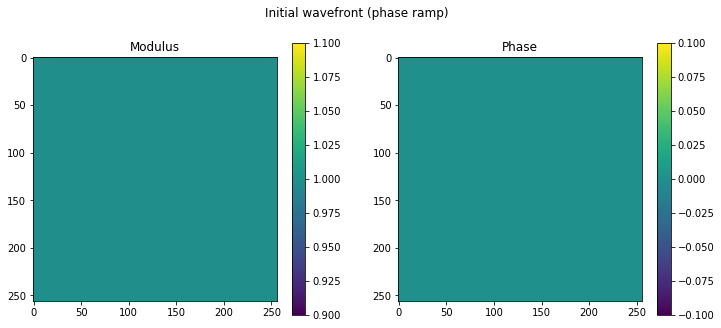

In [16]:
wavefront = initialize_wavefront(psize_cm, s_r_cm, grid_delta.shape[0:2], wavelen_nm, type='plane')
plot_mod_and_phase(wavefront, title='Initial wavefront (phase ramp)', unwrap=False)

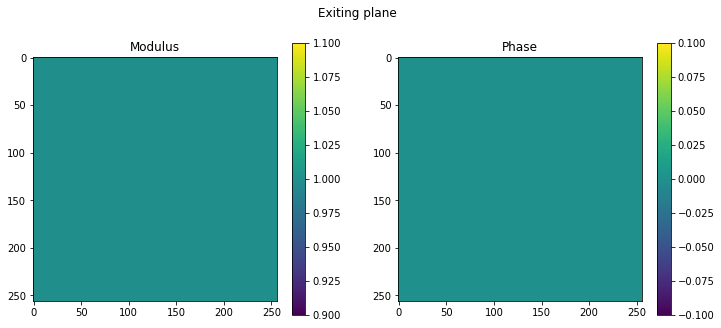

100%|██████████| 256/256 [00:02<00:00, 106.67it/s]


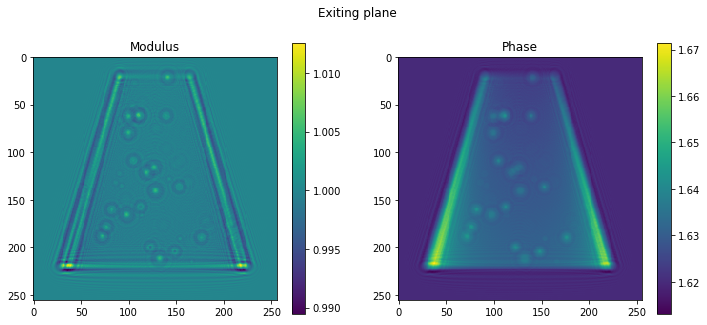

In [17]:
plot_mod_and_phase(wavefront, title='Exiting plane', unwrap=False)

psize_nm = psize_cm * 1.e7
kz = 2 * PI * psize_nm / wavelen_nm
this_psize_cm = psize_cm
for i_slice in tqdm(range(grid_delta.shape[2])):
    delta_slice = grid_delta[:, :, i_slice]
    beta_slice = grid_beta[:, :, i_slice]
    wavefront *= np.exp((kz * delta_slice) * 1j) * np.exp(-kz * beta_slice)
    wavefront = free_propagate_fresnel(wavefront, 
                                       psize_cm, 
                                       wavelen_nm,
                                       psize_cm)
plot_mod_and_phase(wavefront, title='Exiting plane', unwrap=False)
dxchange.write_tiff(np.angle(wavefront), 'exit_phase_old', dtype='float32', overwrite=True)
dxchange.write_tiff(np.abs(wavefront), 'exit_mag_old', dtype='float32', overwrite=True)